Trying to find out if it's possible to include the Mathieson EMH data in our analysis of SFS shift.

In [1]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../R/utils.R")

In [2]:
suppressMessages({

# read processed SNP tables of aDNA samples and SGDP individuals,
# merge them and intersect them with the annotations data
all_snps <- load_dataset("../clean_data/ice_age.tsv",
                         "../clean_data/sgdp.tsv",
                         "../clean_data/archaics.tsv",
                         filter_damage=FALSE,
                         metadata_path="../raw_data/10_24_2014_SGDP_metainformation_update.txt",
                         random_sample=T)

# process the SGDP metainformation table
sgdp_info <-
  load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
  mutate(name=str_replace(name, "^S_", "")) %>%
  filter(name %in% colnames(all_snps)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(pop != "Oceania") %>% 
  #filter(pop == "WestEurasia") %>%
  #mutate(pop="present_Europe") %>% 
  filter(! Country %in% c('Iran', 'Iraq', 'Jordan', 'Israel(Central)',
                          'Israel(Carmel)', 'Israel(Negev)', 'Israel', 'Tajikistan', 'Turkey', 'Yemen',
                          'Abkhazia', 'Armenia'))

emh_info <- # filter out high C-T samples (mainly non-UDG treated ones and weird library preps)
  read_delim("../clean_data/ages.txt", delim=" ") %>%
  mutate(pop="EMH_Europe") %>%
  mutate(Country="EMH_Europe") %>% 
  filter(name %in% colnames(all_snps),
         ! name %in% c("AfontovaGora3", "GoyetQ116_1", "Kotias", "Oase1", "Satsurblia", "Villabruna"))

samples_info <-
  bind_rows(emh_info, sgdp_info) %>%
  mutate(post_admixture=55000 - age)

})

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Warning message:
“Unknown variables: `S_Australian_1`, `S_Australian_5`”Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [3]:
nrow(all_snps)

[1] 484016

## Process the Mathieson et al. SNP data

The dataset contains SNPs from ~230 individuals < 10ky old. The total number of SNPs is ~1.2M, but only a subset of those overlaps my admixture array sites. I want to take this subset and check if I can still find something interesting in terms of Nea. ancestry in these samples.

In [4]:
vcf_path <- "/home/felix_schulze/projects/trpm8_proj/mathiseson_data/MathiesonEtAl_genotypes/full230.vcf.gz"
mathieson_dir <- "../raw_data/MathiesonEtAl_genotypes"
fixed_nea_coords <- file.path(mathieson_dir, "fixed_nea_coords.bed")
full230_path <- file.path(mathieson_dir, "processed_full230.tsv")

In [5]:
# convert the table of SNPs into a BED file
select(all_snps, chrom, pos) %>%
    mutate(start=as.integer(pos-1), end=pos) %>%
    select(-pos) %>%
    write.table(fixed_nea_coords, row.names=F, col.names=F, sep="\t")

In [6]:
system2("sh", c("../get_mathieson_table.sh", fixed_nea_coords, vcf_path, mathieson_dir, full230_path))

In [7]:
x <-
    read_tsv(full230_path) %>%
    random_call %>%
    fix_NA %>%
    select(-c(Kostenki14, Loschbour, Stuttgart)) %>% 
    inner_join(all_snps)
#    inner_join(rename(all_snps, my_Kostenki14=Kostenki14, my_Loschbour=Loschbour, my_Stuttgart=Stuttgart))

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Joining, by = c("chrom", "pos", "ref", "alt")


In [8]:
nrow(x)

[1] 12556

In [9]:
head(x)

chrom,pos,ref,alt,I0235,I0234,I0421,I0431,I0430,I0424,⋯,Spanish_1,Spanish_2,Tajik_1,Tajik_2,Turkish_1,Turkish_2,Tuscan_1,Tuscan_2,Yemenite_Jew_1,Yemenite_Jew_2
1,2420233,G,T,NA,NA,NA,NA,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,2792801,C,T,NA,0,NA,NA,0,NA,⋯,0,0,0,0,0,0,0,0,0,0
1,2903159,A,G,NA,NA,NA,NA,NA,NA,⋯,0,0,2,0,0,0,0,0,0,0
1,2926379,T,C,0,NA,NA,0,2,NA,⋯,0,0,2,0,0,0,0,0,0,0
1,2995262,T,G,0,0,NA,NA,0,NA,⋯,0,0,0,0,2,2,0,0,0,0
1,3006131,T,C,NA,0,NA,NA,NA,NA,⋯,0,0,0,0,0,2,0,0,0,0


In [10]:
table(x$French_1)


    0     2 
11770   786 

In [11]:
table(x$Han_1)


    0     2 
11587   969 

In [12]:
calc_sharing_prop(x, "archaic_Altai", "Yoruba_1")
calc_sharing_prop(all_snps, "archaic_Altai", "Yoruba_1")

[1] 0.005813953

[1] 0.002744539

In [13]:
calc_sharing_prop(x, "archaic_Altai", "Dinka_1")
calc_sharing_prop(all_snps, "archaic_Altai", "Dinka_1")

[1] 0.006610385

[1] 0.00365364

In [14]:
calc_sharing_prop(x, "archaic_Altai", "French_1")
calc_sharing_prop(all_snps, "archaic_Altai", "French_1")

[1] 0.06259955

[1] 0.01811576

In [15]:
calc_sharing_prop(x, "archaic_Altai", "Ust_Ishim")
calc_sharing_prop(all_snps, "archaic_Altai", "UstIshim")

[1] 0.05471246

[1] 0.02859167

In [16]:
calc_sharing_prop(x, "archaic_Altai", "Han_1")
calc_sharing_prop(all_snps, "archaic_Altai", "Han_1")

[1] 0.07717426

[1] 0.02365271

In [17]:
nea_est <-
    samples_info %>% 
    mutate(Mathieson=sapply(samples_info$name, function(s) calc_sharing_prop(x, "archaic_Altai", s)),
           admixture_array=sapply(samples_info$name, function(s) calc_sharing_prop(all_snps, "archaic_Altai", s)))

In [18]:
nea_est %<>% gather(set, nea, -c(name, Country, age, pop, Latitude, Longitude, post_admixture))

In [19]:
head(nea_est)

name,age,pop,Country,Latitude,Longitude,post_admixture,set,nea
UstIshim,45020,EMH_Europe,EMH_Europe,NA,NA,9980,Mathieson,0.05606352
Kostenki14,37470,EMH_Europe,EMH_Europe,NA,NA,17530,Mathieson,0.06540796
Muierii2,33300,EMH_Europe,EMH_Europe,NA,NA,21700,Mathieson,0.06841046
Kostenki12,32415,EMH_Europe,EMH_Europe,NA,NA,22585,Mathieson,0.08015267
Vestonice13,30870,EMH_Europe,EMH_Europe,NA,NA,24130,Mathieson,0.06142506
Vestonice15,30870,EMH_Europe,EMH_Europe,NA,NA,24130,Mathieson,0.06299213


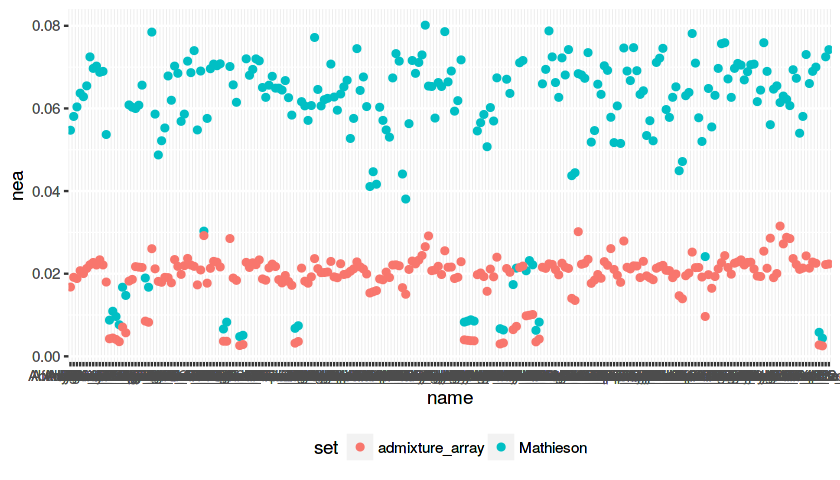

In [20]:
options(repr.plot.width=7, repr.plot.height=4)

ggplot(nea_est, aes(name, nea, color=set)) + geom_point() + theme(legend.position="bottom")

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 3 rows containing missing values (geom_point).”


Call:
lm(formula = .[["admixture_array"]] ~ .[["Mathieson"]])

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0033729 -0.0013113 -0.0004473  0.0005285  0.0179258 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.0025506  0.0004914    5.19 4.59e-07 ***
.[["Mathieson"]] 0.2884623  0.0081432   35.42  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0024 on 232 degrees of freedom
Multiple R-squared:  0.844,	Adjusted R-squared:  0.8433 
F-statistic:  1255 on 1 and 232 DF,  p-value: < 2.2e-16


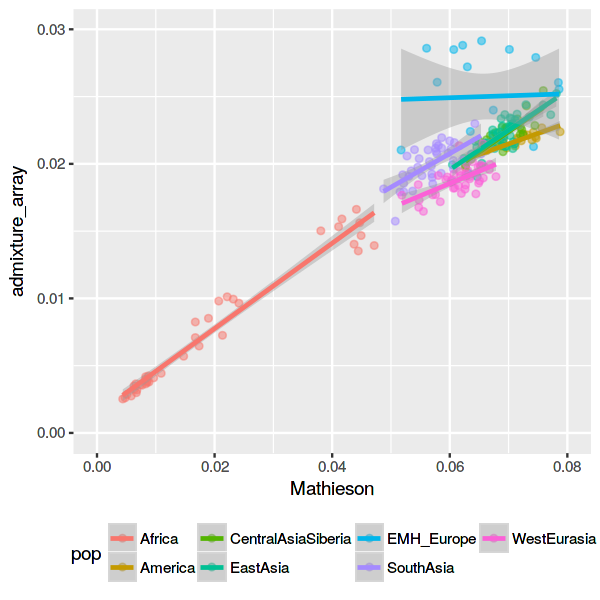

In [21]:
options(repr.plot.width=5, repr.plot.height=5)

spread(nea_est, set, nea) %>% filter(name != "Continenza") %>% ggplot(aes(x=Mathieson, y=admixture_array, color=pop)) +
    geom_point(alpha=1/2) + ylim(0, 0.03) + xlim(0, 0.08) +
    theme(legend.position="bottom") +
    geom_smooth(method="lm")
spread(nea_est, set, nea) %>% { lm(.[["admixture_array"]] ~ .[["Mathieson"]]) } %>% summary

Who are the outliers? SOme other population that wasn't included in the ascertainment?

In [22]:
head(nea_est)

name,age,pop,Country,Latitude,Longitude,post_admixture,set,nea
UstIshim,45020,EMH_Europe,EMH_Europe,NA,NA,9980,Mathieson,0.05606352
Kostenki14,37470,EMH_Europe,EMH_Europe,NA,NA,17530,Mathieson,0.06540796
Muierii2,33300,EMH_Europe,EMH_Europe,NA,NA,21700,Mathieson,0.06841046
Kostenki12,32415,EMH_Europe,EMH_Europe,NA,NA,22585,Mathieson,0.08015267
Vestonice13,30870,EMH_Europe,EMH_Europe,NA,NA,24130,Mathieson,0.06142506
Vestonice15,30870,EMH_Europe,EMH_Europe,NA,NA,24130,Mathieson,0.06299213


Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

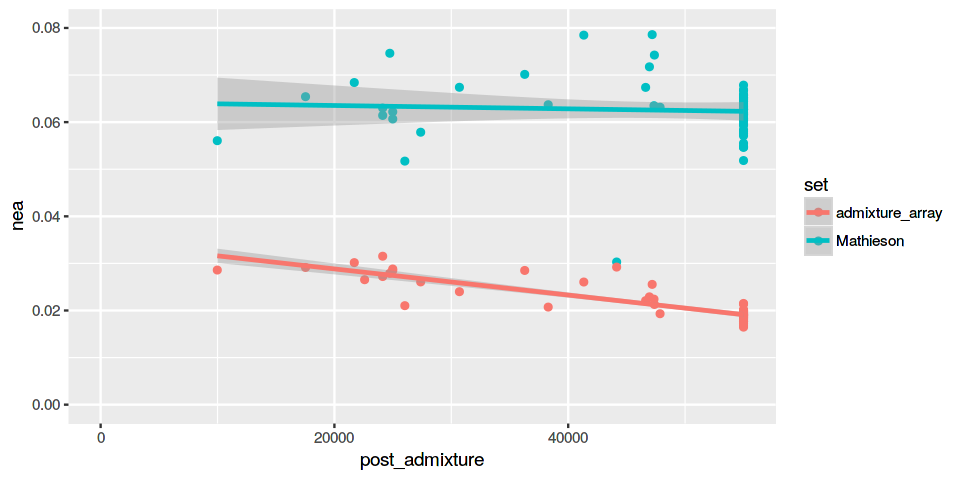

In [25]:
options(repr.plot.width=8, repr.plot.height=4)

ggplot(filter(nea_est, pop %in% c("EMH_Europe", "WestEurasia")), aes(post_admixture, nea, color=set)) +
    geom_point() +
    xlim(0, 55000) + ylim(0, 0.08) +
    geom_smooth(method="lm")